# 1、可视化特征图

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
 
import torchvision
import torchvision.transforms as transforms
 
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
# %config InlineBackend.figure_format = 'svg'
# %matplotlib inline
# %config InlineBackend.figure_format = "retina"

## 可视化函数

In [3]:
from pathlib import Path
# https://www.delftstack.com/zh/howto/matplotlib/how-to-improve-subplot-size-or-spacing-with-many-subplots-in-matplotlib/#plt.subplots_adjust-%25E6%2596%25B9%25E6%25B3%2595%25E6%259B%25B4%25E6%2594%25B9-matplotlib-%25E5%25AD%2590%25E5%259B%25BE%25E9%2597%25B4%25E8%25B7%259D
def vis_maps(feature_maps, cmap='gray', save_name='vis.png', nrows=8, ncols=16, save_dir='vis'):
    """注意： 当cmp='jet'时,由于jet是按照特征图相对值进行染色,所以两张不同的特征图之间没有可比性"""
    plt.figure(figsize=(16, 8))
    for i, filter in enumerate(feature_maps):
        plt.subplot(nrows, ncols, i + 1)
        plt.axis('off')
        # plt.subplots_adjust(left=0.05, bottom=0.05,  right=0.95, top=0.95, wspace=0.1, hspace=0.1)
        plt.imshow(filter, cmap=cmap)
    save_dir = Path(save_dir)
    if not save_dir.exists():
        save_dir.mkdir(exist_ok=True, parents=True)
    save_file = save_dir.joinpath(save_name)
    save_file = save_file.with_name(save_file.stem + '_' + cmap + '.png')
    print(f"{save_file=}")
    plt.savefig(save_file, dpi=600, bbox_inches='tight')
    # plt.savefig(save_file, dpi=600)
    plt.show()
    plt.close()


def vis_two_maps(feature_maps1, feature_maps2, cmap='gray', save_name='vis.png',
                 nrows=2, ncols=128, save_dir='vis'):
    """注意： 当cmp='jet'时,由于jet是按照特征图相对值进行染色,所以两张不同的特征图之间没有可比性，所以应该画在同一张图片上"""
    feature_maps = torch.cat([feature_maps1, feature_maps2], dim=0)
    fig, ax = plt.subplots(nrows, ncols, sharex='all', sharey='all')
    fig.set_size_inches(64, 1)  # 设置合适的画布大小，调整子图间距才会生效
    fig.subplots_adjust(left=0, bottom=0,  right=1, top=1, wspace=0, hspace=0)
    for i in range(nrows):
        for j in range(ncols):
            ax[i, j].axis('off')
            ax[i, j].imshow(feature_maps[j*(i+1)], cmap=cmap)
    save_dir = Path(save_dir)
    if not save_dir.exists():
        save_dir.mkdir(exist_ok=True, parents=True)
    save_file = save_dir.joinpath(save_name)
    save_file = save_file.with_name(save_file.stem + '_' + cmap + '.png')
    print(f"{save_file=}")
    plt.savefig(save_file, dpi=200, bbox_inches='tight')
    # plt.savefig(save_file, dpi=600)
    plt.show()
    plt.close()

def vis_one_image(feature_maps1, feature_maps2, cmap='gray', 
                  save_name='vis.png', save_dir='vis'):
    """注意： 当cmp='jet'时,由于jet是按照特征图相对值进行染色,所以两张不同的特征图之间没有可比性，所以应该两两地画在同一张图片上"""
    channels, h, w = feature_maps1.shape
    _, index  = feature_maps1.sum(dim=2).mean(dim=1).sort()
    feature_maps1 = feature_maps1[index]  # 按均值升序排列
    feature_maps2 = feature_maps2[index]  # 按均值升序排列
    
    feature_maps = torch.tile(feature_maps1, dims=(1, 2, 1))  # [c, 2h, w]

    fig, ax = plt.subplots(1, channels, sharex='all', sharey='all')
    fig.set_size_inches(32, 1)  # 设置合适的画布大小，调整子图间距才会生效, 而且保证保存的图片不会有多余的彩图。
    fig.subplots_adjust(left=0, bottom=0,  right=1, top=1, wspace=0, hspace=0)
    # fig = plt.figure(figsize=(64, 1))
    # 开始画第二行的特征图 feature_maps2
    h1, h2 = h, 2 * h
    for col in range(channels):
        feature_maps[col, h1:h2, 0:w] = feature_maps2[col, :, :]
        ax[col].axis('off')
        ax[col].imshow(feature_maps[col].data, cmap=cmap)

        # plt.subplot(1, channels, col + 1)
        # plt.axis('off')
        # plt.imshow(feature_maps[col].data, cmap=cmap)

    save_dir = Path(save_dir)
    if not save_dir.exists():
        save_dir.mkdir(exist_ok=True, parents=True)
    save_file = save_dir.joinpath(save_name)
    save_file = save_file.with_name(save_file.stem + '_' + cmap + '.png')
    print(f"{save_file=}")
    plt.savefig(save_file, dpi=600, bbox_inches='tight')
    # plt.savefig(save_file, dpi=600)
    # plt.colorbar(plt.cm.ScalarMappable(cmap=cmap))
    plt.show()
    plt.close()


def vis_multi_maps(map_list, cmap='gray', keep_channels=-1, save_name='vis.png', save_dir='vis'):
    """注意： 当cmp='jet'时,由于jet是按照特征图相对值进行染色,所以两张不同的特征图相同通道之间没有可比性，所以应该在同一张图片上"""
    channels, h, w = map_list[0].shape
    for maps in map_list:
        assert maps.shape == (channels, h, w)   # 所有特征图的shape要相同
    
    feature_maps = torch.cat(map_list, dim=1)  # 在高度上拼接，将同一通道的特征图拼接为一张特征图
    _, index  = feature_maps.sum(dim=2).mean(dim=1).sort()
    feature_maps = feature_maps[index]  # 按均值升序排列

    ncols = keep_channels if keep_channels != -1 else channels
    fig, ax = plt.subplots(1, ncols, sharex='all', sharey='all')
    # fig = plt.figure(figsize=(64, 1))
    # 设置合适的画布大小，调整子图间距才会生效, 而且保证保存的图片不会有多余的彩图。
    fig.set_size_inches(ncols // len(map_list), 1)  
    fig.subplots_adjust(left=0, bottom=0,  right=1, top=1, wspace=0, hspace=0)
    # 开始画第二行的特征图 feature_maps2

    for col in range(ncols):
        ax[col].axis('off')
        ax[col].imshow(feature_maps[col].data, cmap=cmap)

    save_dir = Path(save_dir)
    if not save_dir.exists():
        save_dir.mkdir(exist_ok=True, parents=True)
    save_file = save_dir.joinpath(save_name)
    save_file = save_file.with_name(save_file.stem + '_' + cmap + '_ncols' + str(ncols) + '.png')
    print(f"{save_file=}")
    plt.savefig(save_file, dpi=600, bbox_inches='tight')
    # plt.savefig(save_file, dpi=600)
    # plt.colorbar(plt.cm.ScalarMappable(cmap=cmap))
    plt.show()
    plt.close()

def save_two_maps(map1, map2, file_name, padding=2, cmap='jet'):
        '''
            maps(tensor): [channels, hm_height, hm_width]
            file_name: eg. 'heatmap.jpg'
            padding: 每张图片填充边缘距离,便于区分图像边界。
        '''
        batch_maps = torch.stack([map1, map2], dim=0)
        batch_maps = batch_maps.mul(255).clamp(0, 255).byte().cpu().detach().numpy()
        batch_size, channels, hm_height, hm_width = batch_maps.shape
        # 将图片下采样到热图大小
        nrow = channels  # grid网格中每一行有多少张图片
        images = torch.zeros((batch_size*nrow, 3, hm_height, hm_width))
        # [B, C, H, W] -> [BxC, H, W]
        grid = torchvision.utils.make_grid(images, nrow, padding, True)
        ndarr = grid.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()
        ndarr = cv.cvtColor(ndarr, cv.COLOR_RGB2BGR)
        ndarr = ndarr.astype(np.float32)

        # grid中一个网格的宽高
        height = int(hm_height + padding)
        width = int(hm_width + padding)
        half_padding = padding // 2

        for i in range(batch_size):
            for j in range(nrow):
                maps = batch_maps[i, j]
                if cmap == 'jet':  
                    colored_heatmap = cv.applyColorMap(maps, cv.COLORMAP_JET)
                else:
                    colored_heatmap = cv.applyColorMap(maps, cv.COLORMAP_OCEAN)

                h1, h2 = height * i + half_padding, height * (i+1) - half_padding
                w1, w2 = width * j + half_padding, width * (j+1) - half_padding
                ndarr[h1:h2, w1:w2, :] += colored_heatmap

        cv.imwrite(file_name, ndarr.astype(np.uint8))

img.shape=(156, 235, 3)


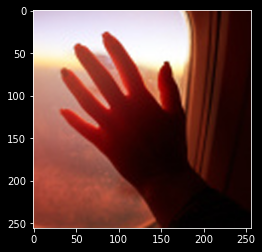

torch.Size([1, 3, 256, 256])


In [4]:
img=cv.imread("./data/handset/OneHand10K/Test/source/1700.jpg")
img=cv.cvtColor(img,cv.COLOR_BGR2RGB)
print(f"{img.shape=}")
img = img[30:140, 90:200, :]
img = cv.resize(img, (256, 256), interpolation=cv.INTER_CUBIC)
plt.imshow(img)
plt.show()


transform = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.RandomResizedCrop(256),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
img=np.array(img)
img=transform(img)
img=img.unsqueeze(0)
print(img.size())

## 定义模型

In [5]:
class DWConv(nn.Module):
    """DepthwiseSeparableConvModul 深度可分离卷积"""
    def __init__(self, in_channel, out_channel, stride=1, padding=1, dilation=1,mid_relu=True, last_relu=True, bias=False):
        super().__init__()
        self.depthwise_conv = nn.Sequential(
            nn.Conv2d(in_channel, in_channel, 3, stride, padding, groups=in_channel, bias=bias, dilation=dilation),
            nn.BatchNorm2d(in_channel))      
        self.mid_relu = nn.ReLU() if mid_relu else nn.Identity()  # 正常的DWConv直接有ReLU
        self.pointwise_conv = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, 1, 1, 0, bias=bias),
            nn.BatchNorm2d(out_channel))
        self.last_relu = nn.ReLU() if last_relu else nn.Identity()  # 正常的DWConv直接有ReLU
        
    def forward(self, x):
        out = self.mid_relu(self.depthwise_conv(x)) 
        out = self.last_relu(self.pointwise_conv(out)) 
        return out
 
class BottleNeck(nn.Module):
    """用于提高深度,但尽可能少地增加运算量, 不改变通道数"""
    def __init__(self, channel):
        super(BottleNeck, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channel, channel // 4, 1, 1, 0),
            nn.BatchNorm2d(channel // 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // 4, channel // 4, 3, 1, 1),
            nn.BatchNorm2d(channel // 4),  
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // 4, channel, 1, 1, 0), 
            nn.BatchNorm2d(channel),  
        )
    def forward(self, x):
        return F.relu(x + self.conv(x))


class BasicBlock(nn.Module):
    def __init__(self, inp_dim, out_dim, stride=1):
        super(BasicBlock, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(inp_dim, out_dim, 3, stride, 1),
            nn.BatchNorm2d(out_dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_dim, out_dim, 3, 1, 1),
            nn.BatchNorm2d(out_dim),  
        )

        if stride == 2 or inp_dim != out_dim:
            self.skip_layer = nn.Sequential(
                nn.Conv2d(inp_dim, out_dim, 1, stride, 0),
                nn.BatchNorm2d(out_dim)
            )
        else:
            self.skip_layer = nn.Identity()
    def forward(self, x):
        return F.relu(self.skip_layer(x) + self.conv(x))

class Residual(nn.Module):
    def __init__(self, inp_dim, out_dim, stride=1, num_block=2):
        super().__init__()
        self.conv1 = BasicBlock(inp_dim, out_dim, stride)
        self.blocks = nn.Sequential(*[BottleNeck(out_dim) for _ in range(num_block)])

    def forward(self, x):
        out = self.conv1(x)
        out = self.blocks(out)
        return out

class BRC(nn.Module):
    """  BN + Relu + Conv2d """    
    def __init__(self, inp_dim, out_dim, kernel_size=3, stride=1, padding=1, bias=False, dilation=1):
        super(BRC, self).__init__()
        self.inp_dim = inp_dim
        self.conv = nn.Conv2d(inp_dim, out_dim, kernel_size, stride,
                            padding=padding, bias=bias, dilation=dilation)
        self.silu = nn.SiLU(inplace=True)
        self.bn = nn.BatchNorm2d(inp_dim)

    def forward(self, x):
        x = self.bn(x)
        x = self.silu(x)
        x = self.conv(x)
        return x


class EncoderDecoder(nn.Module):
    def __init__(self, num_levels=5, inp_dim=128, num_blocks=[]):
        super().__init__()
        self.num_levels = num_levels
        self.encoder = nn.ModuleList([])
        self.decoder = nn.ModuleList([])
        assert len(num_blocks) == num_levels - 1

        self.encoder.append(nn.Sequential(MSFB(inp_dim, inp_dim), SCAB(inp_dim)))
        for i in range(num_levels-1):
            self.encoder.append(Residual(inp_dim, inp_dim, 2, num_blocks[i]))
            self.decoder.append(Residual(inp_dim, inp_dim))
        self.decoder.append(nn.Sequential(MSFB(inp_dim, inp_dim), SCAB(inp_dim)))


    def forward(self, x):
        out_encoder = []   # [128, 64, 32, 16, 8, 4]
        out_decoder = []   # [4, 8, 16, 32, 64, 128]

        # encoder 
        for encoder_layer in self.encoder:
            x = encoder_layer(x)
            out_encoder.append(x)

        # ! 我觉得只添加一次简单的shortcut就够了
        h, w = out_encoder[-1].shape[2:]
        shortcut = F.adaptive_avg_pool2d(out_encoder[0], (h, w))

        # decoder  
        for i, decoder_layer in enumerate(self.decoder):
            counterpart = out_encoder[self.num_levels-1-i]
            if i == 0:
                x = decoder_layer(counterpart)
                x = x + shortcut
            else:
                h, w = counterpart.shape[2:]
                x = decoder_layer(x)
                x = F.interpolate(x, size=(h, w))
                x = x + counterpart
            out_decoder.append(x)
        return tuple(out_decoder) 


class MSFB(nn.Module):
    """
    https://blog.csdn.net/KevinZ5111/article/details/104730835?utm_medium=distribute.pc_aggpage_search_result.none-task-blog-2~aggregatepage~first_rank_ecpm_v1~rank_v31_ecpm-4-104730835.pc_agg_new_rank&utm_term=block%E6%94%B9%E8%BF%9B+residual&spm=1000.2123.3001.4430
    """
    def __init__(self, in_c, out_c):
        super().__init__()

        mid_c = in_c // 2
        self.conv1 = BRC(in_c, mid_c, 1, 1, 0)

        self.mid1_conv = nn.ModuleList([
            nn.Sequential(
                DWConv(mid_c, mid_c // 2),
                DWConv(mid_c // 2, mid_c // 2)
            ), 
            nn.Sequential(
                DWConv(mid_c, mid_c),
                DWConv(mid_c, mid_c),        
            )])

        self.mid2_conv = nn.ModuleList([
            nn.Sequential(
                DWConv(mid_c, mid_c // 2, dilation=2, padding=2),
                DWConv(mid_c // 2, mid_c // 2),),
            nn.Sequential(
                DWConv(mid_c, mid_c, dilation=2, padding=2),
                DWConv(mid_c, mid_c))
            ])

        self.conv2 = BRC(in_c, out_c, 1, 1, 0, bias=False)

    def forward(self, x):
        m = self.conv1(x)
        for i in range(2):
            m1 = self.mid1_conv[i](m)
            m2 = self.mid2_conv[i](m)
            m = torch.cat([m1, m2], dim=1)

        features = m + x
        out = self.conv2(features)
        return out

class SCAB(nn.Module):
    def __init__(self, out_c):
        super().__init__()
        self.att = nn.Sequential(
                    nn.AdaptiveAvgPool2d((3,3)),
                    nn.BatchNorm2d(out_c),
                    nn.ReLU(),
                    nn.Conv2d(out_c, out_c, 3, 1, 0, groups=out_c),
                    nn.Flatten(),
                    nn.Dropout(p=0.3),
                    nn.Linear(out_c, out_c),
                    nn.Sigmoid(),  
                    )
    
    def forward(self, x):
        b, c, _, _ = x.shape
        return x * self.att(x).view(b, c, 1, 1)


class my_pelee_stem(nn.Module):
    """ 我在Conv1中再加了一个3x3卷积, 来提高stem的初始感受野"""
    def __init__(self, out_channel=256, min_mid_c=32):
        super().__init__()
        mid_channel = out_channel // 4 if out_channel // 4 >= min_mid_c else min_mid_c

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, mid_channel, 3, 2, 1, bias=False),
            nn.BatchNorm2d(mid_channel),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(mid_channel, mid_channel, 3, 1, 1,
                      groups=mid_channel, bias=False),
            nn.BatchNorm2d(mid_channel),
            nn.LeakyReLU(inplace=True)
        )
        self.branch1 = nn.Sequential(
            nn.Conv2d(mid_channel, mid_channel, 1, 1, 0),
            nn.BatchNorm2d(mid_channel),
            nn.ReLU(True), 
            nn.Conv2d(mid_channel, mid_channel, 3, 2, 1),
            nn.BatchNorm2d(mid_channel),
            nn.ReLU(True)
        )
        self.branch2 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.conv1x1 = nn.Conv2d(mid_channel * 2, out_channel, 1, 1, 0)

    def forward(self, x):
        out = self.conv1(x)
        b1 = self.branch1(out)
        b2 = self.branch2(out)
        out = torch.cat([b1, b2], dim=1)
        out = self.conv1x1(out)
        return out


class MultiScaleAttentionHourglass(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        num_stage=cfg.MODEL.get('num_stage', 4)
        inp_dim=cfg.MODEL.get('input_channel', 128)
        oup_dim=cfg.MODEL.get('output_channel', cfg.DATASET.channels)
        num_block=cfg.MODEL.get('num_block', [2, 2, 2])
        self.with_activation = cfg.MODEL.get('output_acitivation', False)

        self.pre = my_pelee_stem(inp_dim)
        self.hgs = EncoderDecoder(num_stage, inp_dim, num_block) 

        self.features = nn.Sequential(
                BottleNeck(inp_dim),
                nn.Conv2d(inp_dim, inp_dim, 1, 1, 0),
                nn.BatchNorm2d(inp_dim),
                nn.LeakyReLU(),
            )
        # self.out_layer = nn.Conv2d(inp_dim, oup_dim, 1, 1, 0)
        self.outs = nn.Conv2d(inp_dim, oup_dim, 1, 1, 0)

    def forward(self, imgs):
        # our posenet
        x = self.pre(imgs)
        hg = self.hgs(x)
        feature = self.features(hg[-1])
        preds = self.outs(feature)

        if self.with_activation:  # 加快模型收敛
            preds = F.leaky_relu(preds, 0.5)
        return preds


In [6]:
import addict
# from models import mynet
from utils.training_kits import load_pretrained_state

num_levels = 4
cfg = dict(MODEL=dict(
    num_stage=num_levels,
    num_block=[2, 2, 2],
    input_channel=128,
    ca_type='ca',
    reduction=4,
    output_channel=21,
))

# model = mynet(addict.Dict(cfg))
model = MultiScaleAttentionHourglass(addict.Dict(cfg))
print(model)

MultiScaleAttentionHourglass(
  (pre): my_pelee_stem(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (branch1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (branch2): MaxPo

## 加载模型参数

In [7]:
checkpoint_file = "checkpoints/onehand10k/mynet/4/best_model.pth"
save_dict = torch.load(checkpoint_file, map_location=torch.device('cpu'))
state_dict = save_dict['state_dict']
# state_dict, is_match = load_pretrained_state(model.state_dict(), state_dict)
# print(f"reload model => {checkpoint_file}\n=> \t{is_match=}")
# assert is_match, "model pth not match the code of current model!"
model_state_dict = model.state_dict()
flag = False
for k1, k2 in zip(state_dict.keys(), model_state_dict.keys()):
    v1 = state_dict[k1]
    v2 = model_state_dict[k2]
    if v1.shape == v2.shape:
        model_state_dict[k2] = v1
    else:
        flag = True
if flag:
    print("not match!!")
model.load_state_dict(model_state_dict)
model.eval()

MultiScaleAttentionHourglass(
  (pre): my_pelee_stem(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (branch1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (branch2): MaxPo

## 1.1各个模块

In [8]:
stem = model.pre
encoder = model.hgs.encoder
MSFB1 = model.hgs.encoder[0][0]
SCAB1 = model.hgs.encoder[0][1]
decoder = model.hgs.decoder
MSFB2 = model.hgs.decoder[-1][0]
SCAB2 = model.hgs.decoder[-1][1]
features = model.features
head = model.outs

## 1.2 stem

save_file=PosixPath('vis/stem_jet.png')


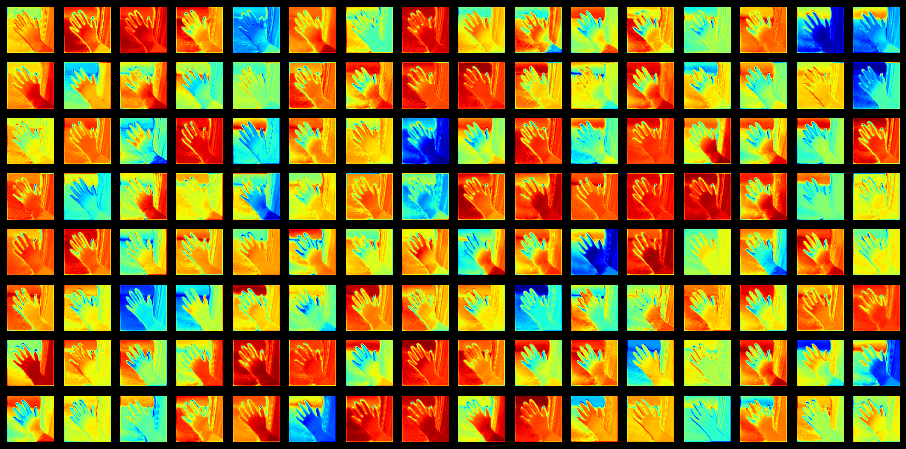

save_file=PosixPath('vis/stem_gray.png')


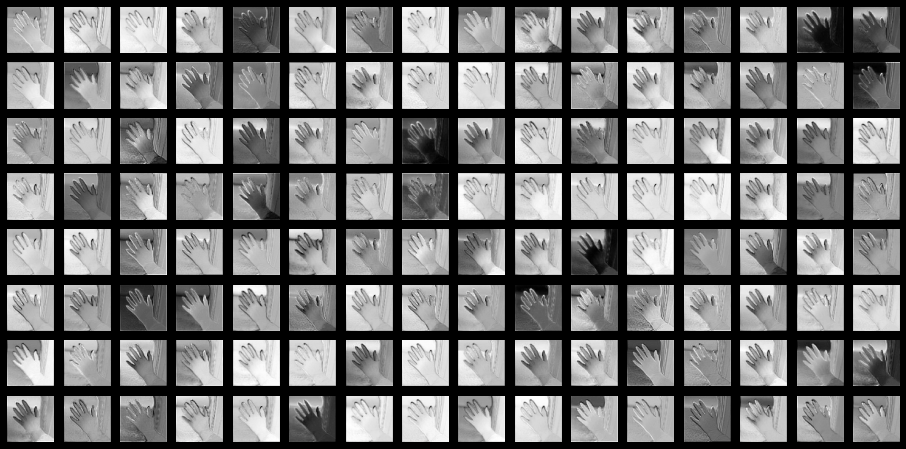

torch.Size([1, 128, 64, 64])

In [9]:
out_stem = stem(img)
vis_maps(out_stem[0].data, cmap='jet', save_name="./stem.png")
vis_maps(out_stem[0].data, cmap='gray', save_name="./stem.png")
out_stem.shape

## 1.3 Encoder-Decoder

In [10]:
x = out_stem
out_encoder = []   # [128, 64, 32, 16, 8]
out_decoder = []   # [8, 16, 32, 64, 128]

# encoder 
for i, encoder_layer in enumerate(encoder):
    if i == 0:
        x = encoder_layer[0](x)
        out_msrb1 = x.clone()
        x = encoder_layer[1](x)
        out_scab1 = x.clone()
    else:
        x = encoder_layer(x)
    out_encoder.append(x)

# ! 我觉得只添加一次简单的shortcut就够了
h, w = out_encoder[-1].shape[2:]
shortcut = F.adaptive_avg_pool2d(out_encoder[0], (h, w))

# decoder  
for i, decoder_layer in enumerate(decoder):
    counterpart = out_encoder[num_levels-1-i]
    if i == 0:
        x = decoder_layer(counterpart)
        x = x + shortcut
    elif i == num_levels - 1:
        h, w = counterpart.shape[2:]
        out_before_msrb2 = x.clone()
        x = decoder_layer[0](x)
        out_msrb2 = x.clone()
        x = decoder_layer[1](x)
        out_scab2 = x.clone()
        x = F.interpolate(x, size=(h, w))
        x = x + counterpart
    else:
        h, w = counterpart.shape[2:]
        x = decoder_layer(x)
        x = F.interpolate(x, size=(h, w))
        x = x + counterpart
    out_decoder.append(x)
out = tuple(out_decoder) 
len(out), out[0].shape

(4, torch.Size([1, 128, 8, 8]))

### 总图

save_file=PosixPath('vis/effect1_jet_ncols10.png')


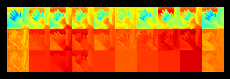

save_file=PosixPath('vis/effect1_gray_ncols10.png')


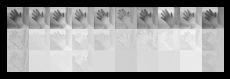

save_file=PosixPath('vis/effect2_jet_ncols10.png')


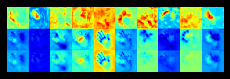

save_file=PosixPath('vis/effect2_gray_ncols10.png')


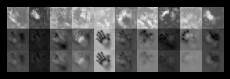

In [11]:
maps1 = [out_stem[0].data, out_msrb1[0].data, out_scab1[0].data]
# vis_multi_maps(map_list=maps1, cmap='jet', save_name="./effect1.png")
# vis_multi_maps(map_list=maps1, cmap='gray', save_name="./effect1.png")
vis_multi_maps(map_list=maps1, cmap='jet', save_name="./effect1.png", keep_channels=10)
vis_multi_maps(map_list=maps1, cmap='gray', save_name="./effect1.png", keep_channels=10)

maps2 = [out_before_msrb2[0].data, out_msrb2[0].data, out_scab2[0].data]
# vis_multi_maps(map_list=maps2, cmap='jet', save_name="./effect2.png")
# vis_multi_maps(map_list=maps2, cmap='gray', save_name="./effect2.png")
vis_multi_maps(map_list=maps2, cmap='jet', save_name="./effect2.png", keep_channels=10)
vis_multi_maps(map_list=maps2, cmap='gray', save_name="./effect2.png", keep_channels=10)

save_file=PosixPath('vis/effect1_jet_ncols128.png')


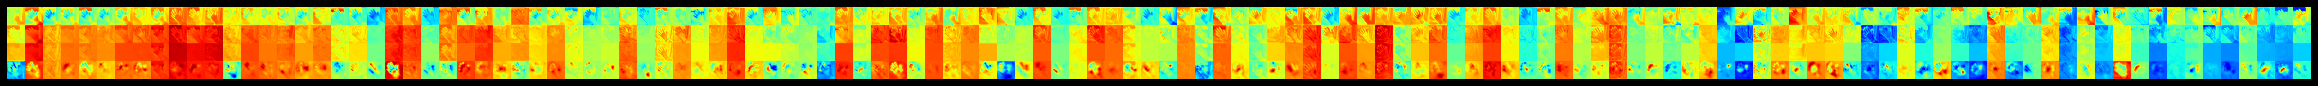

save_file=PosixPath('vis/effect1_gray_ncols128.png')


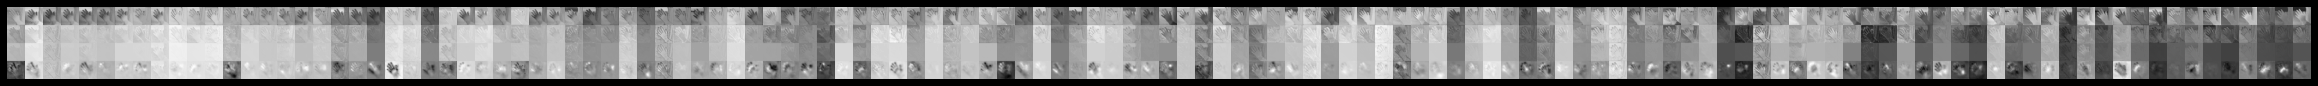

save_file=PosixPath('vis/effect2_jet_ncols128.png')


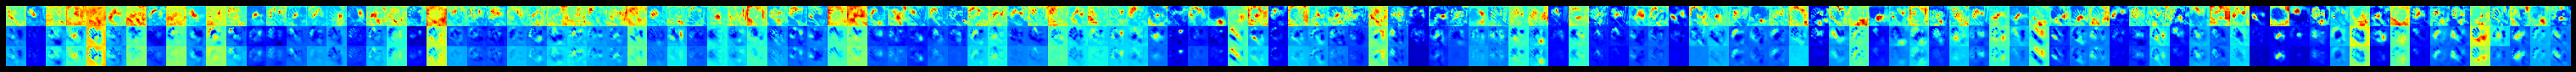

save_file=PosixPath('vis/effect2_gray_ncols128.png')


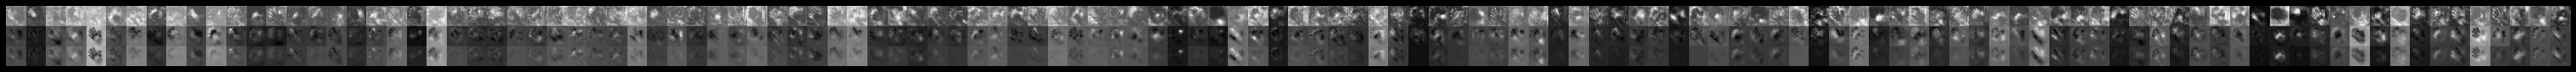

In [12]:
maps1 = [out_stem[0].data, out_msrb1[0].data, out_scab1[0].data, out_decoder[-1][0].data]
# vis_multi_maps(map_list=maps1, cmap='jet', save_name="./effect1.png")
# vis_multi_maps(map_list=maps1, cmap='gray', save_name="./effect1.png")

vis_multi_maps(map_list=maps1, cmap='jet', save_name="./effect1.png")
vis_multi_maps(map_list=maps1, cmap='gray', save_name="./effect1.png")

maps2 = [out_before_msrb2[0].data, out_msrb2[0].data, out_scab2[0].data]
vis_multi_maps(map_list=maps2, cmap='jet', save_name="./effect2.png")
vis_multi_maps(map_list=maps2, cmap='gray', save_name="./effect2.png")

### 各层大小

In [13]:
for e in out_encoder:
    print(e.shape)
print()
for d in out_decoder:
    print(d.shape)

torch.Size([1, 128, 64, 64])
torch.Size([1, 128, 32, 32])
torch.Size([1, 128, 16, 16])
torch.Size([1, 128, 8, 8])

torch.Size([1, 128, 8, 8])
torch.Size([1, 128, 16, 16])
torch.Size([1, 128, 32, 32])
torch.Size([1, 128, 64, 64])


### Stem-MSRB1的差值图

save_file=PosixPath('vis/stem_MSRB1_two_jet.png')


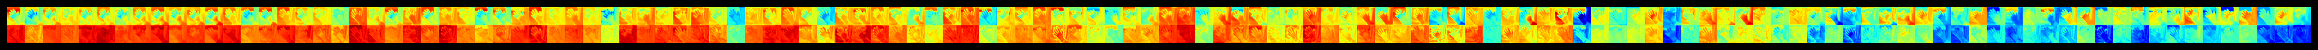

save_file=PosixPath('vis/stem_MSRB1_two_gray.png')


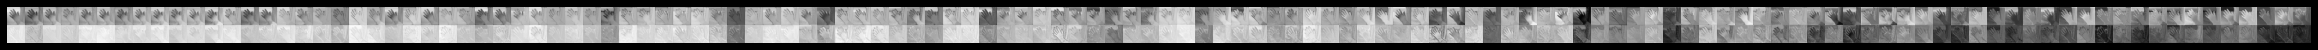

In [14]:
# vis_maps(out_stem[0].data - out_msrb1[0].data, cmap='jet', save_name="./stem_MSRB1.png")
# vis_maps(out_stem[0].data - out_msrb1[0].data, cmap='gray', save_name="./stem_MSRB1.png")

vis_one_image(out_stem[0].data, out_msrb1[0].data, cmap='jet',
              save_name="./stem_MSRB1_two.png")
vis_one_image(out_stem[0].data, out_msrb1[0].data, cmap='gray',
              save_name="./stem_MSRB1_two.png")

# vis_two_maps(out_stem[0].data, out_msrb1[0].data, cmap='jet', save_name="./stem_MSRB1_two.png")
# vis_two_maps(out_stem[0].data, out_msrb1[0].data, cmap='gray', save_name="./stem_MSRB1_two.png")

# save_two_maps(out_stem[0].data, out_msrb1[0].data, cmap='jet', file_name="./stem_MSRB1_two_jet.png")
# save_two_maps(out_stem[0].data, out_msrb1[0].data, cmap='jet', file_name="./stem_MSRB1_two.png")

### encoder ME-att

save_file=PosixPath('vis/MSRB-SCAB1_two_jet.png')


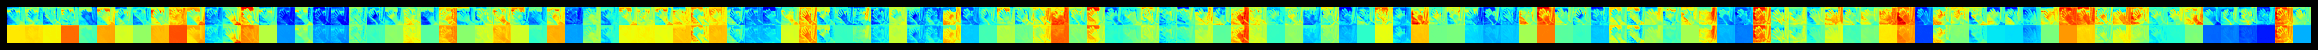

save_file=PosixPath('vis/MSRB-SCAB1_two_gray.png')


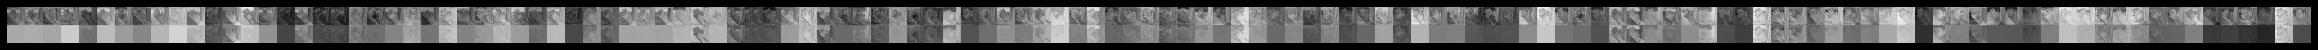

In [15]:
# 输入特征图必须是ndarry[C, H, W]
# msrb1_maps = out_msrb1[0].data
# scab1_maps = out_scab1[0].data

# vis_maps(msrb1_maps, cmap='jet', save_name="./MSRB1.png")
# vis_maps(msrb1_maps, cmap='gray', save_name="./MSRB1.png")

# vis_maps(scab1_maps, cmap='jet', save_name="./SCAB1.png")
# vis_maps(scab1_maps, cmap='gray', save_name="./SCAB1.png")

# vis_maps(msrb1_maps - scab1_maps, cmap='jet', save_name="./MSRB-SCAB1.png")
# vis_maps(msrb1_maps - scab1_maps, cmap='gray', save_name="./MSRB-SCAB1.png")

# vis_two_maps(out_msrb1[0].data, out_scab1[0].data, cmap='jet', save_name="./MSRB-SCAB1_two.png")
# vis_two_maps(out_msrb1[0].data, out_scab1[0].data, cmap='gray', save_name="./MSRB-SCAB1_two.png")
vis_one_image(out_msrb1[0].data, out_scab1[0].data, cmap='jet', save_name="./MSRB-SCAB1_two.png")
vis_one_image(out_msrb1[0].data, out_scab1[0].data, cmap='gray', save_name="./MSRB-SCAB1_two.png")

# vis_two_maps(out_msrb2[0].data, out_scab2[0].data, cmap='jet', save_name="./MSRB-SCAB2_two.png")
# vis_two_maps(out_msrb2[0].data, out_scab2[0].data, cmap='gray', save_name="./MSRB-SCAB2_two.png")

### decoder ME-att

save_file=PosixPath('vis/MSRB-SCAB2_two_jet.png')


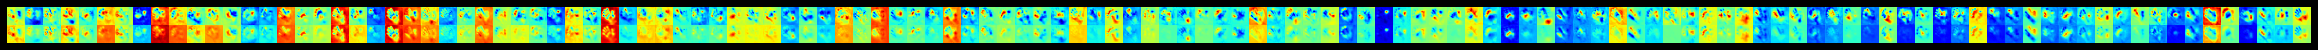

save_file=PosixPath('vis/MSRB-SCAB2_two_gray.png')


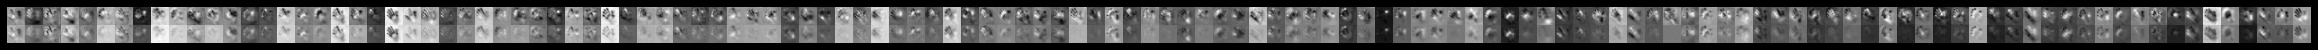

In [16]:
# vis_maps(out_msrb2[0].data, cmap='jet', save_name="./MSRB2.png")
# vis_maps(out_msrb2[0].data, cmap='gray', save_name="./MSRB2.png")

# vis_maps(out_scab2[0].data, cmap='jet', save_name="./SCAB2.png")
# vis_maps(out_scab2[0].data, cmap='gray', save_name="./SCAB2.png")

# vis_maps(out_msrb2[0].data - out_scab2[0].data, cmap='jet', save_name="./MSRB_SCAB2.png")
# vis_maps(out_msrb2[0].data - out_scab2[0].data, cmap='gray', save_name="./MSRB_SCAB2.png")

vis_one_image(out_msrb2[0].data, out_scab2[0].data, cmap='jet', save_name="./MSRB-SCAB2_two.png")
vis_one_image(out_msrb2[0].data, out_scab2[0].data, cmap='gray', save_name="./MSRB-SCAB2_two.png")

## 1.4 最终热图

save_file=PosixPath('vis/hm_gray.png')


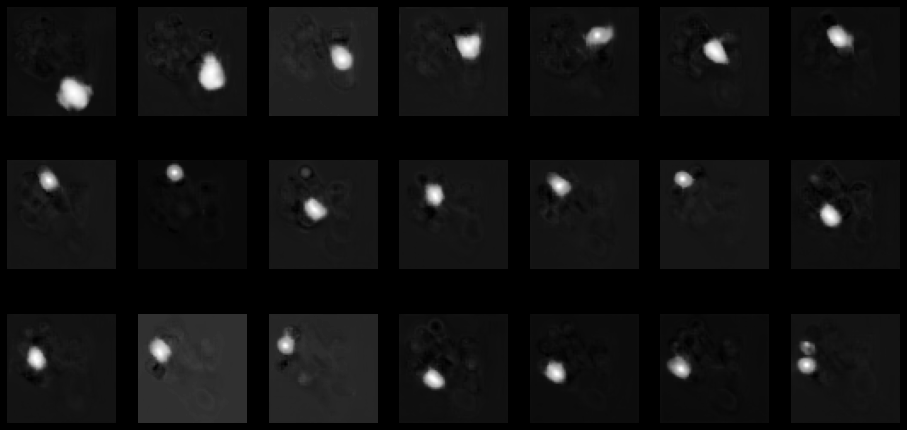

save_file=PosixPath('vis/hm_jet.png')


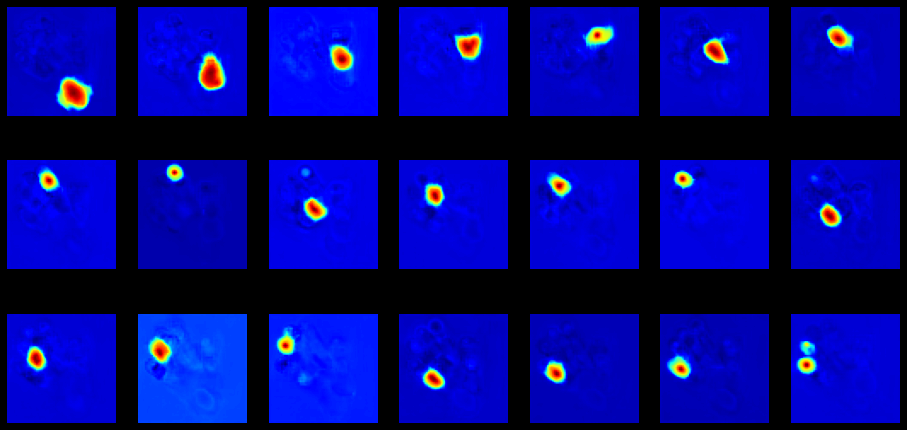

In [17]:
out = features(out[-1])
out = head(out)
feature_maps = out[0, :, :, :]
feature_maps = feature_maps.data
vis_maps(feature_maps, cmap='gray', save_name="./hm.png", nrows=3, ncols=7)
vis_maps(feature_maps, cmap='jet', save_name="./hm.png", nrows=3, ncols=7)

# 2、LiteHRNet30

In [18]:
from models import mynet, litehrnet
cfg_litehrnet = dict(MODEL=dict(
        name='litehrnet',
        depth=30,
        output_channel=21,  # num_joints + 3 region map
))
net = litehrnet(addict.Dict(cfg_litehrnet))
net

LiteHRNet(
  (stem): StemModule(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (branch1): DWConv(
      (depthwise_conv): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (mid_relu): Identity()
      (pointwise_conv): Sequential(
        (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (last_relu): ReLU()
    )
    (expand_conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (depthwise_conv): Sequential(